# Spacematrix indicators regression

## Input data

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('./../data/blocks.parquet')[['geometry', 'land_use', 'fsi', 'gsi', 'mxi']]
blocks_gdf.loc[blocks_gdf.fsi<blocks_gdf.gsi, 'fsi'] = blocks_gdf.gsi
blocks_gdf=blocks_gdf.head(1000)
blocks_gdf.head()

,geometry,land_use,fsi,gsi,mxi
id,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,0.054497,0.017345,0.700000
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",transport,0.444238,0.217986,0.211541
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,0.003234,0.003205,0.700000
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,0.235746,0.056437,0.660753
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,0.086291,0.025381,0.692085


In [2]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks_gdf)

2025-03-03 23:17:26.019 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:8 - Generating nodes.
2025-03-03 23:17:26.020 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:13 - Generating edges.
2025-03-03 23:17:26.072 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:32 - Adjacency graph successfully generated: 1000 nodes, 827 edges


## Preprocessing data for GNN training

### Initializing `x` from geometries and land use

In [3]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import features_from_geometries

geometries_features = features_from_geometries(blocks_gdf)
geometries_features.head()

2025-03-03 23:17:27.436 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_usual_features:35 - Calculating usual features.
2025-03-03 23:17:27.468 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_radiuses:46 - Calculating radiuses.
100%|██████████| 1000/1000 [00:04<00:00, 248.97it/s]
2025-03-03 23:17:32.892 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_aspect_ratios:58 - Calculating radiuses.
100%|██████████| 1000/1000 [00:00<00:00, 20377.61it/s]


,x,y,area,length,corners_count,outer_radius,inner_radius,aspect_ratio
id,,,,,,,,
0,0.589154,-1.074523,0.187591,0.927933,0.894237,0.920124,0.654289,-0.070379
1,0.655564,-1.211727,-0.490105,-0.766060,-0.490520,-0.664795,-0.985832,4.847272
2,0.535681,-1.069510,-0.195333,-0.262073,-0.108894,-0.348299,0.026236,-0.463787
3,0.639388,-1.163228,-0.339835,-0.316822,-0.228834,-0.155159,-0.677929,0.088052
4,0.486773,-1.268475,1.035291,0.817001,0.632550,1.043379,1.921558,-0.189853


In [4]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import features_from_land_use

land_use_features = features_from_land_use(blocks_gdf)
land_use_features.head()

,residential,business,recreation,industrial,transport,special,agriculture
id,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0


In [5]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import initialize_x

x = initialize_x(geometries_features, land_use_features)
x

tensor([[ 0.5892, -1.0745,  0.1876,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6556, -1.2117, -0.4901,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5357, -1.0695, -0.1953,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.4059,  1.9281,  0.8267,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2595,  1.8346,  0.0665,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2672,  1.8799,  4.3601,  ...,  0.0000,  0.0000,  0.0000]])

### Initializing `edge_index`

In [6]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import initialize_edge_index

edge_index = initialize_edge_index(adjacency_graph)
edge_index

tensor([[  0,   0,   1,  ..., 995, 997, 998],
        [419,   3,   3,  ..., 996, 999, 999]])

### Initializing `y`

In [7]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import initialize_y

y = initialize_y(blocks_gdf)
y

tensor([[5.4497e-02, 1.7345e-02, 7.0000e-01],
        [4.4424e-01, 2.1799e-01, 2.1154e-01],
        [3.2338e-03, 3.2051e-03, 7.0000e-01],
        ...,
        [4.2519e-03, 2.6628e-03, 5.7726e-01],
        [3.8411e-02, 3.8408e-02, 6.8459e-01],
        [3.7304e-04, 2.8932e-04, 5.4004e-01]])

### Splitting train and test data

In [8]:
from blocksnet.machine_learning.spacematrix_regression.preprocessing import split_train_and_test

train_mask, test_mask = split_train_and_test(y)
train_mask, test_mask

(tensor([ True,  True,  True, False,  True,  True,  True,  True,  True, False,
         False, False,  True,  True, False,  True,  True,  True,  True, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True, False,  True, False,  True,  True, False,
          True,  True, False,  True,  True, False,  True,  True,  True,  True,
          True,  True, False, False, False,  True, False,  True,  True,  True,
          True,  True,  True, False,  True, False,  True,  True, False,  True,
          True,  True, False,  True,  True,  True,  True, False,  True,  True,
         False,  True,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False,  True,  True,  True,  True,  True, False,  True, False,
          True,  True,  True,  True,  True,  True,  

## GNN

### Train

In [9]:
from blocksnet.machine_learning.spacematrix_regression import train_model

model, losses = train_model(x, edge_index, y, train_mask, epochs=10_000)

2025-03-03 23:17:33.262 | WARNING  | blocksnet.machine_learning.spacematrix_regression.model:train_model:24 - No model is provided. Initializing.
Current loss : 0.031: 100%|██████████| 10000/10000 [00:30<00:00, 324.16it/s]


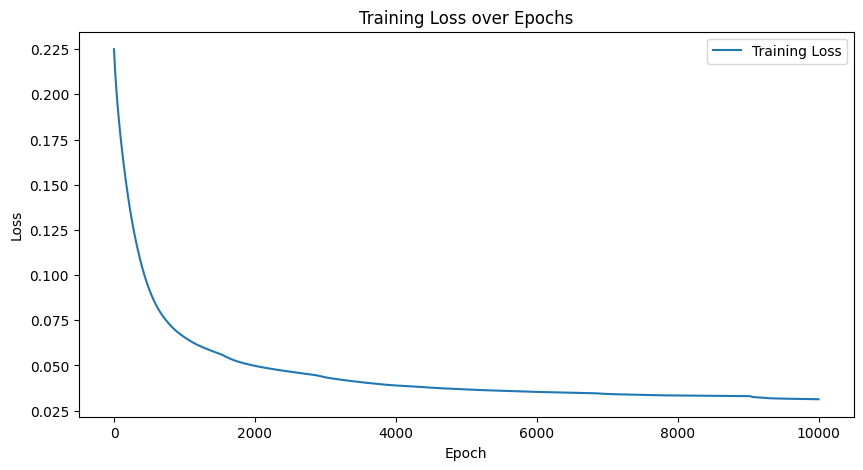

In [10]:
from blocksnet.machine_learning.spacematrix_regression import plot_losses

plot_losses(losses)

### Test

In [11]:
from blocksnet.machine_learning.spacematrix_regression import test_model

loss, out = test_model(model, x, edge_index, y, test_mask)
loss

0.061975955963134766

In [12]:
out

tensor([[0.0746, 0.0746, 0.3628],
        [0.0155, 0.0155, 0.0335],
        [0.0503, 0.0503, 0.4029],
        ...,
        [0.0146, 0.0146, 0.2526],
        [0.0282, 0.0282, 0.3457],
        [0.0017, 0.0017, 0.3854]])

### Eval

In [13]:
from blocksnet.machine_learning.spacematrix_regression import eval_model

out = eval_model(model, x, edge_index)
out

tensor([[0.0746, 0.0746, 0.3628],
        [0.0155, 0.0155, 0.0335],
        [0.0503, 0.0503, 0.4029],
        ...,
        [0.0146, 0.0146, 0.2526],
        [0.0282, 0.0282, 0.3457],
        [0.0017, 0.0017, 0.3854]])

In [14]:
from blocksnet.machine_learning.spacematrix_regression import out_to_df

out_df = out_to_df(blocks_gdf, out)
out_df.head()

,fsi,gsi,mxi
id,,,
0,0.074619,0.074619,0.362845
1,0.015539,0.015539,0.033484
2,0.050343,0.050343,0.402887
3,0.456077,0.049879,0.145223
4,0.029392,0.029392,0.557989


## Visualization

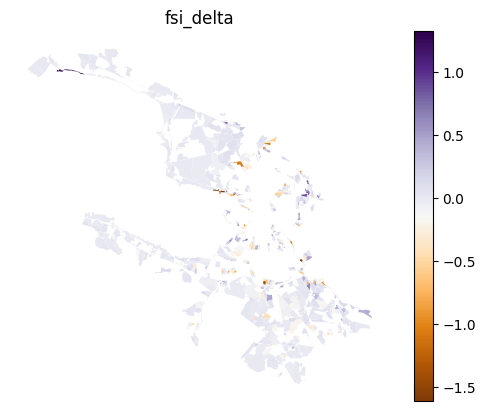

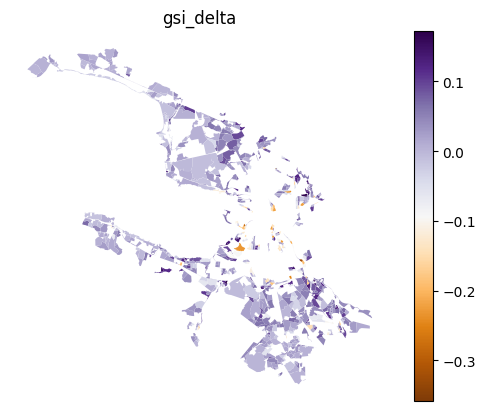

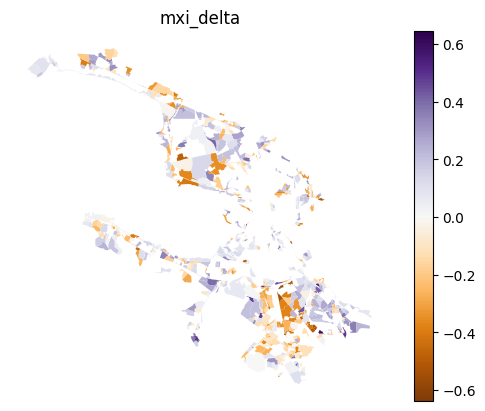

In [15]:
gdf = blocks_gdf.copy()   
for column in ['fsi', 'gsi', 'mxi']:
    delta_column = f'{column}_delta'
    gdf[delta_column] = out_df[column] - gdf[column]
    ax = gdf.plot(column=delta_column, cmap='PuOr', legend=True)
    ax.set_axis_off()
    ax.set_title(delta_column)